<center>

# **HEDGING STRATEGIES ANALYSIS**

</center>




*<br>**Gabriele Marras**<br> University of Technology of Sydney <br> UTS - Mathematical and Physical Sciences*

In [819]:
#Loading Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

**DATA FRAME**

In [820]:
#Setting Data Frames 
df_WTI = pd.read_csv('Cushing_OK_WTI_Spot_Price_FOB.csv', on_bad_lines='skip', skiprows=4, parse_dates=[0])
df_JF = pd.read_csv('U.S._Gulf_Coast_Kerosene-Type_Jet_Fuel_Spot_Price_FOB.csv', on_bad_lines='skip', skiprows=4, parse_dates=[0])
df_Futures = pd.read_excel('Crude Oil May 24.xlsx', parse_dates=[0])
df_Futures = df_Futures.drop(df_Futures.columns[[1, 2, 3, 4, 6]], axis=1)

df_WTI['Day'] = pd.to_datetime(df_WTI['Day'])
df_JF['Day'] = pd.to_datetime(df_JF['Day'])
df_Futures['Date'] = pd.to_datetime(df_Futures['Date'])

df_WTI = df_WTI.rename(columns={'Cushing OK WTI Spot Price FOB  Dollars per Barrel': 'Prices'})
df_JF = df_JF.rename(columns={'U.S. Gulf Coast Kerosene-Type Jet Fuel Spot Price FOB  Dollars per Gallon': 'Prices'})
df_WTI = df_WTI.rename(columns={'Day': 'Date'})
df_JF = df_JF.rename(columns={'Day': 'Date'})
df_Futures = df_Futures.rename(columns={'Adj Close**': 'Prices'})

df_WTI['Date'] = pd.to_datetime(df_WTI['Date'])
df_JF['Date'] = pd.to_datetime(df_JF['Date'])
df_Futures['Date'] = pd.to_datetime(df_Futures['Date'])

print("                WTI    ", "JF   ", "Futures")
print("-------------------------------------")
print(pd.concat([df_WTI.head(), df_JF['Prices'].head(), df_Futures['Prices'].head()], axis=1))

                WTI     JF    Futures
-------------------------------------
        Date  Prices  Prices  Prices
0 2024-03-25   82.41   2.583   81.95
1 2024-03-22   81.10   2.582   80.63
2 2024-03-21   81.99   2.608   81.07
3 2024-03-20   82.79   2.606   81.68
4 2024-03-19   84.39   2.671   83.47


In [821]:
#Fixing missing values
df_WTI.set_index('Date', inplace=True)
df_Futures.set_index('Date', inplace=True)

df_WTI = df_WTI.reindex(df_Futures.index)

df_WTI['Prices'] = df_WTI['Prices'].interpolate(method='time')

df_WTI.reset_index(inplace=True)
df_Futures.reset_index(inplace=True)

##############################################

df_JF.set_index('Date', inplace=True)
df_Futures.set_index('Date', inplace=True)

df_JF = df_JF.reindex(df_Futures.index)

df_JF['Prices'] = df_JF['Prices'].interpolate(method='time')

df_JF.reset_index(inplace=True)
df_Futures.reset_index(inplace=True)

Difference: &rarr; $\Delta{P} = P_t - P_{t-1}$

In [822]:
#Setting Difference
df_WTI['Difference'] = df_WTI['Prices'].diff()
df_JF['Difference'] = df_JF['Prices'].diff()
df_Futures['Difference'] = df_Futures['Prices'].diff()

# 1. Hedge WTI Crude Oil using Futures on Crude Oil

In [823]:
#Definition of Hedge Parameters
contract_size = 1000
hedge_size = 100000
start_date = '2023-11-01'
end_date = '2024-03-19'

<span style="font-size: 1.5em;">*a. Optimal hedge using Futures*</span>

The minimum variance hedge ratio is: &rarr; $h^* = \rho \cdot \frac{\sigma_S}{\sigma_F}$

The optimal number of futures contracts for hedging is: &rarr; $N^* = h^*\cdot \frac{Q_S}{Q_F}$

Where:  
- $\sigma_S$ is the Standard Deviation of $\Delta S$ changes in the spot price
- $\sigma_F$ is the Standard Deviation of $\Delta F$ changes in the futures price

- $\rho$ is the correlation between $\Delta S$ and $\Delta F$

- $Q_S$ is the size of the position to be hedged
- $Q_F$ is the size of one futures contract

In [824]:
#Calculation of the optimal number of contracts to long
df_WTI_Q1 = df_WTI[(df_WTI['Date'] >= start_date) & (df_WTI['Date'] <= end_date)]
df_Futures_Q1 = df_Futures[(df_Futures['Date'] >= start_date) & (df_Futures['Date'] <= end_date)]

st_dev_WTI = df_WTI_Q1['Difference'].std()
st_dev_Futures = df_Futures_Q1['Difference'].std()
corr_WTI_Futures = df_WTI_Q1['Difference'].corr(df_Futures_Q1['Difference'])

h = corr_WTI_Futures * (st_dev_WTI / st_dev_Futures)

N = h * (hedge_size / contract_size)

print('The optimal number of contracts h* to long is', int(N))

The optimal number of contracts h* to long is 99


<span style="font-size: 1.5em;">*b. Price of the hedge*</span>

In [825]:
#Net price of the hedge position
unhedged_price = df_WTI_Q1['Difference'] * hedge_size
print('The unhedged price is', f"${sum(unhedged_price)}")
print('The unhedged level of risk is', unhedged_price.std())

hedged_price = unhedged_price - (contract_size * df_Futures_Q1['Difference']) * N
print('The hedged price is', f"${sum(hedged_price)}")
print('The hedged level of risk is', hedged_price.std())

R_2 = (h**2 * (st_dev_Futures**2 / st_dev_WTI**2))**2
print('The hedge effectiveness of the optimal hedge ratio is', R_2)

The unhedged price is $-174000.00000000087
The unhedged level of risk is 146030.74737907163
The hedged price is $-50485.16129738759
The hedged level of risk is 22000.232660019243
The hedge effectiveness of the optimal hedge ratio is 0.9551214118590152


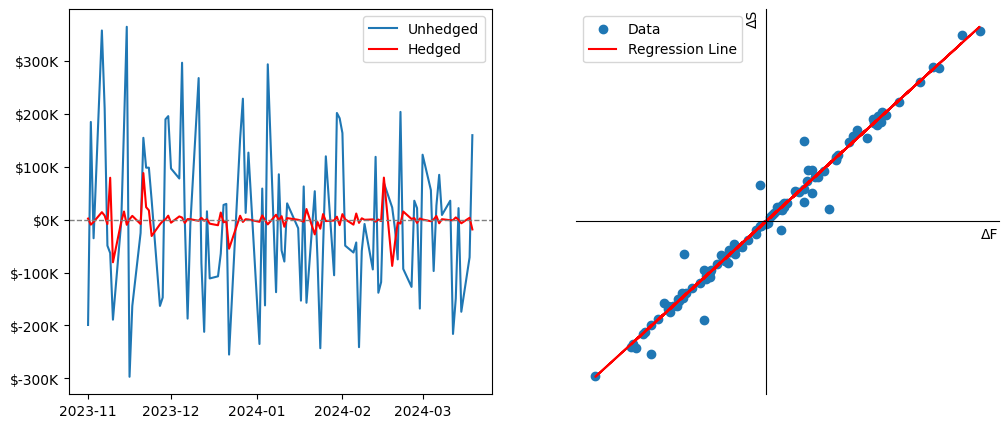

In [826]:
#Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#first subplot: Plotting
ax[0].plot(df_WTI_Q1['Date'], unhedged_price, label='Unhedged')
ax[0].plot(df_WTI_Q1['Date'], hedged_price, label='Hedged', color = 'r')
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '${:,.0f}K'.format(x * 1e-3)))
ax[0].axhline(y=0, color='gray', linestyle='--', lw=1)
ax[0].legend()

#Second subplot: Regression Line
X = sm.add_constant(df_Futures_Q1['Difference'])
model = sm.OLS(df_WTI_Q1['Difference'], X)
results = model.fit()

ax[1].scatter(df_Futures_Q1['Difference'], df_WTI_Q1['Difference'], label='Data')
ax[1].plot(df_Futures_Q1['Difference'], results.predict(), color='red', label='Regression Line')
ax[1].set_xlabel('ΔF', ha='right', x=1)
ax[1].set_ylabel('ΔS', ha='right', y=1)
ax[1].legend()
ax[1].spines['bottom'].set_position(('data', 0))
ax[1].spines['left'].set_position(('data', 0))
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

<span style="font-size: 1.5em;">*c. Discussion*</span>

The optimal number of contracts to buy is 99.61. This means that the company should buy about 100 futures contracts to best hedge the risk associated with buying WTI crude oil.

The unhedged price is -USD 174,000.00 and the unhedged risk level is 146,030.75. After hedging, the price becomes -USD 50,485.16 and the risk level is reduced to 22,000.23. This shows that hedging has effectively reduced the risk level.

The effectiveness of hedging with the optimal hedge ratio is 0.9551. This indicates that hedging was very effective, covering about 95.51% of the risk.

Regarding basis risk, it refers to the discrepancy between the price of the asset you are trying to hedge and the price of the futures contract used for hedging. In this case, since the effectiveness of the hedge is very high, we can infer that the basis risk is relatively low. However, there is still a small part of the risk, about 4.49%, that has not been hedged, which is the residual basis risk.

# 2. Hedge Kerosene Jet Fuel using Futures on Crude Oil

In [827]:
#Definition of Hedge Parameters
contract_size = 1000
hedge_size = 1000000
start_date = '2023-11-01'
end_date = '2024-03-19'

<span style="font-size: 1.5em;">*a. Optimal hedge using Futures*</span>

The minimum variance hedge ratio is: &rarr; $h^* = \rho \cdot \frac{\sigma_S}{\sigma_F}$

The optimal number of futures contracts for hedging is: &rarr; $N^* = h^*\cdot \frac{Q_S}{Q_F}$

Where:  
- $\sigma_S$ is the Standard Deviation of $\Delta S$ changes in the spot price
- $\sigma_F$ is the Standard Deviation of $\Delta F$ changes in the futures price

- $\rho$ is the correlation between $\Delta S$ and $\Delta F$

- $Q_S$ is the size of the position to be hedged
- $Q_F$ is the size of one futures contract

In [828]:
#Calculation of the optimal number of contracts to long
df_JF_Q2 = df_JF[(df_JF['Date'] >= start_date) & (df_JF['Date'] <= end_date)]
df_Futures_Q2 = df_Futures[(df_Futures['Date'] >= start_date) & (df_Futures['Date'] <= end_date)]

st_dev_JF = df_JF_Q2['Difference'].std()
st_dev_Futures = df_Futures_Q2['Difference'].std()
corr_JF_Futures = df_JF_Q2['Difference'].corr(df_Futures_Q2['Difference'])

h = corr_JF_Futures * (st_dev_JF / st_dev_Futures)

N = h * (hedge_size / contract_size)

print('The optimal number of contracts h* to long is', int(N))

The optimal number of contracts h* to long is 30


<span style="font-size: 1.5em;">*b. Price of hedge*</span>

In [829]:
#Net price of the hedge position
unhedged_price = df_JF_Q2['Difference'] * hedge_size
print('The unhedged net price is', f"${sum(unhedged_price)}")
print('The unhedged level of risk is', unhedged_price.std())

hedged_price = unhedged_price - (contract_size * df_Futures_Q2['Difference']) * N
print('The hedged net price is', f"${sum(hedged_price)}")
print('The hedged level of risk is', hedged_price.std())

R_2 = (h**2 * (st_dev_Futures**2 / st_dev_JF**2))**2
print('The hedge effectiveness of the optimal hedge ratio is', R_2)

The unhedged net price is $269000.0000000001
The unhedged level of risk is 70139.18530836844
The hedged net price is $306806.1654641642
The hedged level of risk is 54469.652366000155
The hedge effectiveness of the optimal hedge ratio is 0.15753132475907247


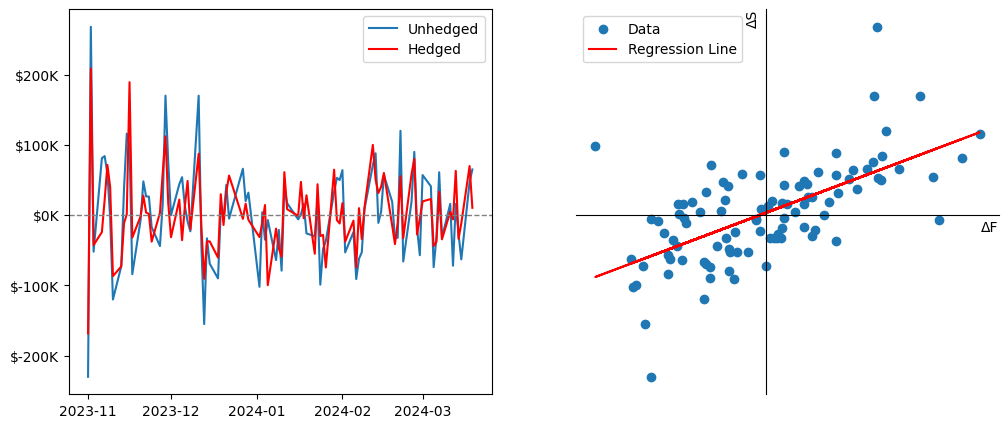

In [830]:
#Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#first subplot: Plotting
ax[0].plot(df_JF_Q2['Date'], unhedged_price, label='Unhedged')
ax[0].plot(df_JF_Q2['Date'], hedged_price, label='Hedged', color='r')
ax[0].axhline(y=0, color='gray', linestyle='--', lw=1)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '${:,.0f}K'.format(x * 1e-3)))
ax[0].legend()

#Second subplot: Regression Line
X = sm.add_constant(df_Futures_Q2['Difference'])
model = sm.OLS(df_JF_Q2['Difference'], X)
results = model.fit()

ax[1].scatter(df_Futures_Q2['Difference'], df_JF_Q2['Difference'], label='Data')
ax[1].plot(df_Futures_Q2['Difference'], results.predict(), color='red', label='Regression Line')
ax[1].set_xlabel('ΔF', ha='right', x=1)
ax[1].set_ylabel('ΔS', ha='right', y=1)
ax[1].legend()
ax[1].spines['bottom'].set_position(('data', 0))
ax[1].spines['left'].set_position(('data', 0))
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

<span style="font-size: 1.5em;">*c. Discussion and Comparison*</span>

The optimal number of contracts to purchase is 30.4888. This means that the company should buy about 30 futures contracts to best hedge the risk associated with the purchase of kerosene jet fuel.

The unhedged price is USD 269,000.00 and the unhedged risk level is 70,139.18. After hedging, the price becomes USD 306,806.16 and the risk level is reduced to 54,469.65. Again, hedging has reduced the risk level but at higher cost; futures contracts to buy are often more expensive than buying the underlying itself.

However, the effectiveness of hedging with the optimal hedge ratio is only 0.1575, thus covering only about 15.75% of the risk.

In the strategy concerning the purchase of WTI crude oil, hedging was very effective, amounting to about 95.51% of the risk. In the one concerning the purchase of kerosene
jet fuel, however, hedging was less effective, covering only about 15.75% of the risk. This could be because the price of kerosene jet fuel and the price of the WTI crude oil futures contract do not move perfectly together. In addition, the basis risk is significantly higher in the second strategy than in the first, indicating a larger discrepancy between the price of the asset being hedged and the price of the futures contract used for hedging.

# 3.  Arbitrage Opportunity Long Forward and Short Future

In [831]:
#Definition of Arbitrage information
forward_price = 78
forward_size = 1000000
future_size = 1000
start_date = datetime(2022, 1, 12)
end_date = datetime(2023, 12, 8)

<span style="font-size: 1.5em;">*a. Outcome of the arbitrage*</span>


The net position of the long forward contract is: &rarr; ${forward} = (S_{\text{T}} - K) \cdot \text{N°of barrels}$

The net position of the short future contract is: &rarr; ${futures} = (f_{\text{T}_0} - f_{\text{T}} ) \cdot \text{N°futures contract} \cdot \text{Contract Size}$

Where: 

- $S_{\text{T}}$ is the spot price of WTI Crude Oil at maturity  
  
- $K$ is the strike price
  
- $f_{\text{T}_0}$ is the market price of the futures on the purchase day

- $f_{\text{T}}$ is the market price of the futures on the sale day
 
The net position of the Hedge Fund is the sum of $forward_{\text{long}}$ and $futures_{\text{short}}$

In [832]:
#calculation of net position
df_WTI_Q3 = df_WTI[(df_WTI['Date'] >= start_date) & (df_WTI['Date'] <= end_date)]
df_Futures_Q3 = df_Futures[(df_Futures['Date'] >= start_date) & (df_Futures['Date'] <= end_date)]


long_forward = (df_WTI_Q3.loc[df_WTI_Q3.loc[df_WTI_Q3['Date'] == end_date,'Date'].index[0], 'Prices'] - forward_price) * forward_size
short_future = (df_Futures_Q3.loc[df_Futures_Q3.loc[df_Futures_Q3['Date'] == start_date,'Date'].index[0], 'Prices'] - df_Futures_Q3.loc[df_Futures_Q3.loc[df_Futures_Q3['Date'] == end_date,'Date'].index[0], 'Prices']) * future_size * contract_size
net_position = long_forward + short_future

print('The net position of the Hedge Fund is', (f"${int(net_position)}"))

The net position of the Hedge Fund is $4280000


<span style="font-size: 1.5em;">*b. Total capital of Hedge Fund*</span>

In [833]:
#setting the margin account
maintenance_margin = 6000 * 1000
initial_capital = 18000000
intrest_rate = 0.03
margin_intrest = 0.02

The gain/loss from the short position on the future is: &rarr; $\text{Gain/loss} = \left( f_{\text{T}_0} - f_{\text{T}} \right) \cdot \text{N°futures contract} \cdot \text{Contract Size}$

Interest on the cash account is calculated as: &rarr; $\text{Cash Account} = \text{C}_T \cdot e^{(\text{r} \cdot (T / 365))}$

Interest on the margin account is calculated as: &rarr; $\text{Margin Balance} = \text{C}_T \cdot \left(1 + \text{r}\right)^{\frac{T}{365}}$

When there is a margin call on the margin account, this is set as: 

1) $\Delta = \text{Maintenance Margin} - \text{Margin Balance}_T$

2) $\text{Margin Balance}_{T+1:n} = \text{Margin Balance}_{T+1:n} + \Delta$

3) $\text{Cash Account}_{T+1:n} = \text{Cash Account}_{T+1:n} - \Delta$  

The hedge fund's capital is:

- $\text{Hedge Fund Capital} = forward_{\text{long}} + \text{Margin Balance}$

- $\text{Total Hedge Fund Capital} = forward_{\text{long}} + \text{Margin Balance} + \text{Cash Account}$

In [834]:
#calculation of total capital
capital = initial_capital - maintenance_margin
df_Futures_Q3 = df_Futures_Q3.sort_values(by='Date').reset_index(drop=True)
df_Futures_Q3['Gain/loss'] = ((df_Futures_Q3.loc[df_Futures_Q3.loc[df_Futures_Q3['Date'] == start_date,'Date'].index[0], 'Prices'] - df_Futures_Q3['Prices']) * contract_size * future_size)
df_Futures_Q3['Margin Balance'] = df_Futures_Q3['Gain/loss'] + maintenance_margin

df_Futures_Q3['Cash Account'] = capital
df_Futures_Q3['Cash Account'] = df_Futures_Q3['Cash Account'].apply(lambda x: max(x, 0))
df_Futures_Q3 = df_Futures_Q3.astype({'Cash Account': float})
for i in range(len(df_Futures_Q3)):
    df_Futures_Q3.loc[i, 'Cash Account'] = (capital * np.exp(intrest_rate * ( i / 365)))

for i in range(len(df_Futures_Q3)):
    df_Futures_Q3.loc[i, 'Margin Balance'] = (df_Futures_Q3.at[i, 'Margin Balance'] * (1 + margin_intrest) ** (i / 365))

for i in range(len(df_Futures_Q3)):
    if df_Futures_Q3.at[i, 'Margin Balance'] < maintenance_margin:
        diff = maintenance_margin - df_Futures_Q3.at[i, 'Margin Balance']
        df_Futures_Q3.loc[i+1:, 'Margin Balance'] += diff
        df_Futures_Q3.loc[i+1:, 'Cash Account'] -= diff

lower_bound_MB = (df_Futures_Q3['Cash Account'].shift(2) < 0) & (df_Futures_Q3['Margin Balance'].shift(2) < maintenance_margin)
df_Futures_Q3.loc[lower_bound_MB, 'Margin Balance'] = None
lower_bound_CA = df_Futures_Q3['Cash Account'].shift() < 0
df_Futures_Q3.loc[lower_bound_CA, ['Cash Account']] = None
df_Futures_Q3.iloc[(df_Futures_Q3.index.get_loc(df_Futures_Q3.index[df_Futures_Q3['Margin Balance'].isnull()][0]))+1:, df_Futures_Q3.columns.get_loc('Margin Balance')] = None 

hedge_fund_capital = round(long_forward)
print('The total capital of the Hedge Fund is', (f"${0}"))

The total capital of the Hedge Fund is $0


The total value of the hedge fund's capital is USD 0 because: not having enough liquidity to cover the margin calls, the clearing house had to liquidate the short futures position the day after the call, as a result the hedge fund had to declare bankruptcy, which is why the long froward position also has a value of USD 0, as it will not be able to honour the payment on the settlement date.

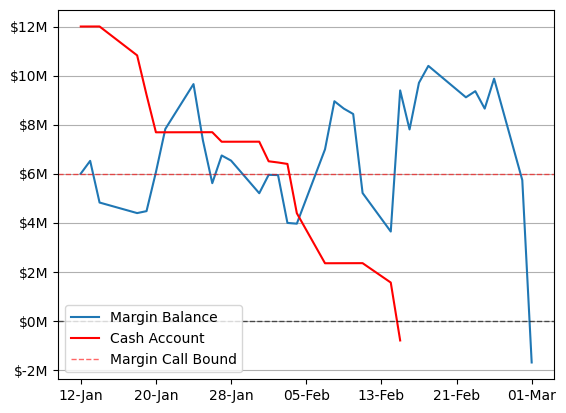

In [835]:
#plotting
plt.plot(df_Futures_Q3['Date'], df_Futures_Q3['Margin Balance'], label='Margin Balance')
plt.plot(df_Futures_Q3['Date'], df_Futures_Q3['Cash Account'], label='Cash Account', color='r')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '${:,.0f}M'.format(x * 1e-6)))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.grid(axis='y')
plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.6)
plt.axhline(y=maintenance_margin, color='r', linestyle='--', lw=1, alpha=0.6, label='Margin Call Bound')
plt.legend(loc='lower left')
plt.show()

<span style="font-size: 1.5em;">*c. Hedge Fund’s total capital with long position on forward*</span>

Interest on the cash account is calculated as: &rarr; $\text{Cash Account} = \text{C}_T \cdot e^{(\text{r} \cdot (T / 365))}$

The capital of the hedge fund is: &rarr; $\text{Total Hedge Fund Capital} = forward_{\text{long}} + \text{Cash Account}$

In [836]:
#calculation of total capital with only forward
capital = initial_capital
cash_account_point_c = pd.DataFrame(index=range(len(df_Futures_Q3)), columns=['Cash Account'])
for i in range(len(df_Futures_Q3)):
    cash_account_point_c.loc[i, 'Cash Account'] = capital * np.exp(intrest_rate * (i / 365))

total_hedge_fund_capital_only_forward = cash_account_point_c['Cash Account'].iloc[-1] + long_forward

print('The total capital of the hedge fund considering only the long position on the forward is', (f"${int(total_hedge_fund_capital_only_forward)}"))

The total capital of the hedge fund considering only the long position on the forward is $11594331


<span style="font-size: 1.5em;">*d. Discussion*</span>

In the first case, where the hedge fund entered into both the forward contract and the futures contracts to hedge the position, the net profit was USD 4,280,000. This means that the hedge fund was able to lock in a profit of USD 4,280,000 by closing out the futures position when the forward contract settled in cash on 8 December 2023.

In the second scenario, the hedge fund entered into a long forward contract, hedged it with futures and faced margin calls.
In this case, the hedge fund suffered significant losses that consumed all the cash held in the current account, forcing the Clearing House to liquidate the short futures position because the fund was no longer able to meet margin calls.  
In fact, on 1 March the spot price of Crude oil exceeded USD 100 per barrel, this increase caused the Margin Account to fall below the maintenance margin of USD 6M generating the Margin Call that the fund was unable to satisfy.
The liquidation of the futures position and the lack of liquidity forced the fund to declare bankruptcy.
the value of the forward contract to be hedged, once declared bankrupt, is also zero as the fund will not be able to repay the counterparty on settlement day.

In the third case, if the Hedge fund had only taken the long position in the forward contract without hedging it using futures, the total capital of the hedge fund on 9 December 2023 would have been USD 11,594,331.

These outcomes indicate that hedging the forward position with futures resulted in a lower total capital compared to not hedging, but it also reduced the risk of the hedge fund's position. Without the hedge, the total capital of the hedge fund would have been higher, but the risk exposure would also have been higher.

If we assume the existence of the same cash account in the first scenario as well, this would be the best scenario of all because, in addition to the gain from hedging with futures, we also consider the hedge fund's cash account. It is useful to assume this scenario as well in order to compare "on an equal footing" the impact of hedging with or without futures margin account transactions.

This hypothesis highlights the importance of considering the cash account in evaluating the effectiveness of hedging strategies. It becomes apparent that the second scenario, where margin calls were not met, led to the most unfavorable outcome. In this case, it would have been even better not to use any hedging at all. This underscores the significant impact of futures margin account transactions on the determination of the hedge fund's profit/loss.